## anaconda prompt 열어서 pip install catboost 하고 conda install seaborn 해주면 됩니다

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error
import lightgbm as lgb
import catboost as cat

In [2]:
train = pd.read_csv('train_V2.csv')

In [3]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [4]:
def rstr(df, pred=None):
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/obs) *100
    skewness = df.skew()
    kurtosis = df.kurt()
    print('Data shape: ', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis', 'corr']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis=1)
    else:
        corr = df.corr()[pred]
        str =pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis=1, sort=False)
        corr_col = 'corr ' + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis',  corr_col]
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

### feature들의 대략적인 통계치, 마지막 열은 target과의 상관계수를 의미 -> 1에 가까울수록 target과의 선형관계가 높다고 볼 수 있음
### but 선형관계를 나타내는 지표이기 때문에 낮다고 해서 아예 관계가 없다고 볼 수는 없다.

In [5]:
pd.set_option('display.max_rows', None)
details = rstr(train, 'winPlacePerc')
display(details.sort_values(by='corr winPlacePerc', ascending=False))

Data shape:  (4446966, 29)
___________________________
Data types:
 int64      19
float64     6
object      4
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing ration,uniques,skewness,kurtosis,corr winPlacePerc
winPlacePerc,float64,4446965,3001,1,0.000022,"[[0.4444, 0.64, 0.7755, 0.1667, 0.1875, 0.037,...",0.098830,-1.245390,1.000000
walkDistance,float64,4446966,38599,0,0.000000,"[[244.8, 1434.0, 161.8, 202.7, 49.75, 34.7, 13...",1.092797,0.990674,0.810888
boosts,int64,4446966,27,0,0.000000,"[[0, 1, 2, 3, 4, 6, 5, 9, 7, 8, 11, 10, 13, 14...",1.949959,4.299439,0.634234
weaponsAcquired,int64,4446966,97,0,0.000000,"[[1, 5, 2, 3, 6, 4, 9, 7, 0, 8, 11, 10, 13, 14...",2.572307,59.355482,0.583806
damageDealt,float64,4446966,29916,0,0.000000,"[[0.0, 91.47, 68.0, 32.9, 100.0, 8.538, 51.6, ...",2.958920,20.112894,0.440507
heals,int64,4446966,63,0,0.000000,"[[0, 5, 2, 14, 12, 1, 8, 3, 4, 6, 9, 13, 7, 24...",3.444345,18.699277,0.427857
kills,int64,4446966,58,0,0.000000,"[[0, 1, 4, 2, 9, 3, 5, 6, 8, 7, 14, 13, 15, 12...",3.362907,27.438769,0.419916
longestKill,float64,4446966,28284,0,0.000000,"[[0.0, 58.53, 18.44, 49.83, 37.91, 9.158, 36.0...",3.944918,24.295268,0.410154
killStreaks,int64,4446966,18,0,0.000000,"[[0, 1, 2, 4, 3, 5, 6, 7, 10, 14, 8, 9, 11, 12...",1.252573,2.115793,0.377566
rideDistance,float64,4446966,33562,0,0.000000,"[[0.0, 0.0045, 2004.0, 6639.0, 1228.0, 1237.0,...",3.346419,14.812228,0.342915


## 그래프 상으로 봤을 때 주요 변수 모두 오른쪽으로 꼬리가 긴 것을 확인할 수 있음 -> outlier 제거 + 루트, 로그 씌워주는 것으로 해결

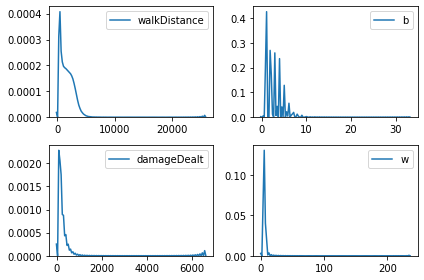

In [14]:
plt.subplot(2,2,1)
sns.kdeplot(train.walkDistance)
plt.tight_layout()

plt.subplot(2,2,2)
sns.kdeplot(train.boosts)
plt.legend("boosts")
plt.tight_layout()
# plt.title("boost")

plt.subplot(2,2,3)
sns.kdeplot(train.damageDealt)
plt.tight_layout()

plt.subplot(2,2,4)
sns.kdeplot(train.weaponsAcquired)
# plt.xlim(train.weaponsAcquired.min())
plt.legend("weaponsAcquired")
plt.tight_layout()

plt.show()

C:\Users\shjas\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


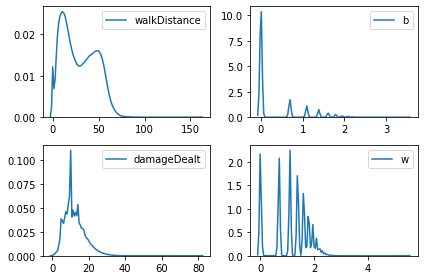

In [17]:
## ex)
wd = np.sqrt(train.walkDistance)
bo = np.log(train.boosts)
bo.replace([-np.inf, np.inf], 0, inplace=True)
dd = np.sqrt(train.damageDealt)
wa = np.log(train.weaponsAcquired)
wa.replace([-np.inf, np.inf], 0, inplace=True)

plt.subplot(2,2,1)
sns.kdeplot(wd)
plt.tight_layout()

plt.subplot(2,2,2)
sns.kdeplot(bo)
plt.legend("boosts")
plt.tight_layout()
# plt.title("boost")

plt.subplot(2,2,3)
sns.kdeplot(dd)
plt.tight_layout()

plt.subplot(2,2,4)
sns.kdeplot(wa)
# plt.xlim(train.weaponsAcquired.min())
plt.legend("weaponsAcquired")
plt.tight_layout()

plt.show()

### feature와 target 분리 및 필요 없는 변수 제거

In [7]:
target = train['winPlacePerc']
target = target.fillna(target.mean())
train.drop(['Id', 'groupId', 'matchId', 'matchType', 'winPlacePerc'], axis=1, inplace=True)

In [8]:
train.isnull().sum()

assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
dtype: int64

In [10]:
x_train, x_val, y_train, y_val = train_test_split(train, target, train_size = 0.7, test_size = 0.3, random_state=0)

In [11]:
val_ds = cat.Pool(x_val, y_val)

### CUDA 환경 세팅이 되어 있지 않다면 아래 CatBoostRegressor 객체 파라미터 중 task_type='GPU' 부분 지울 것

In [12]:
lr = LinearRegression()
ridge = Ridge(alpha=1.0)
cat = cat.CatBoostRegressor(max_depth=13, n_estimators=4000, loss_function='MAE', eval_metric='MAE',learning_rate=0.01,
                            task_type='GPU',l2_leaf_reg=3.0, use_best_model=True)

In [13]:
lr_model = lr.fit(x_train, y_train)
ridge_model = ridge.fit(x_train, y_train)

## baseline Model

In [15]:
print("단순 회귀 r_square(train) : %.2f" % (lr_model.score(x_train, y_train)))
print("릿지 회귀 r_square(train) : %.2f\n" % (ridge_model.score(x_train, y_train)))

print("단순 회귀 MAE(train) : %.3f" % (mean_absolute_error(y_train, lr_model.predict(x_train))))
print("릿지 회귀 MAE(train) : %.3f\n" % (mean_absolute_error(y_train, ridge_model.predict(x_train))))

print("단순 회귀 r_square(val) : %.2f" % (lr_model.score(x_val, y_val)))
print("릿지 회귀 r_square(val) : %.2f\n" % (ridge_model.score(x_val, y_val)))

print("단순 회귀 MAE(val) : %.3f" % (mean_absolute_error(y_val, lr_model.predict(x_val))))
print("릿지 회귀 MAE(val) : %.3f" % (mean_absolute_error(y_val, ridge_model.predict(x_val))))

단순 회귀 r_square(train) : 0.83
릿지 회귀 r_square(train) : 0.83

단순 회귀 MAE(train) : 0.093
릿지 회귀 MAE(train) : 0.093

단순 회귀 r_square(val) : 0.83
릿지 회귀 r_square(val) : 0.83

단순 회귀 MAE(val) : 0.093
릿지 회귀 MAE(val) : 0.093


## Catboost Model

In [16]:
cat_model = cat.fit(x_train, y_train, eval_set=val_ds, early_stopping_rounds=200, metric_period=100)

0:	learn: 0.2637467	test: 0.2637755	best: 0.2637755 (0)	total: 111ms	remaining: 7m 22s
100:	learn: 0.0661848	test: 0.0662590	best: 0.0662590 (100)	total: 10.3s	remaining: 6m 36s
200:	learn: 0.0594891	test: 0.0596124	best: 0.0596124 (200)	total: 19.9s	remaining: 6m 16s
300:	learn: 0.0580966	test: 0.0583344	best: 0.0583344 (300)	total: 29.6s	remaining: 6m 3s
400:	learn: 0.0574977	test: 0.0578099	best: 0.0578099 (400)	total: 39.1s	remaining: 5m 50s
500:	learn: 0.0570603	test: 0.0574883	best: 0.0574883 (500)	total: 48.8s	remaining: 5m 40s
600:	learn: 0.0566715	test: 0.0572345	best: 0.0572345 (600)	total: 58.6s	remaining: 5m 31s
700:	learn: 0.0563267	test: 0.0570340	best: 0.0570340 (700)	total: 1m 8s	remaining: 5m 21s
800:	learn: 0.0560570	test: 0.0569100	best: 0.0569100 (800)	total: 1m 18s	remaining: 5m 11s
900:	learn: 0.0557565	test: 0.0567768	best: 0.0567768 (900)	total: 1m 27s	remaining: 5m 2s
1000:	learn: 0.0555426	test: 0.0567021	best: 0.0567021 (1000)	total: 1m 38s	remaining: 4m 54s


## learn: ***  -> 훈련 데이터  mae
## test : *** -> 검증 데이터 mae

## 둘의 차이가 벌어진다는 것 -> overfitting